# Multivariate analyses of tongue contours from ultrasound tongue

imaging. Draft v0.7

Stefano Coretta [](https://orcid.org/0000-0001-9627-5532) (University of Edinburgh)  
Georges Sakr [](https://orcid.org/0000-0003-3813-2669) (University of Edinburgh)  
April 23, 2025

# Introduction

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

> **Warning**
>
> This is a “living” draft, meaning it is work in progress. While the code is fully functional and usable, we will be updating the textual explanation and might make minor changes to the code to improve clarity. Please, if using in research, cite the version you have consulted. The version of the draft is given in the title as “Draft vX.X” where “X” are incremental digits. See citation recommendation at the bottom of the document.

Ultrasound Tongue Imaging (UTI) is a non-invasive technique that allows researchers to image the shape of the tongue during speech at medium temporal resolution (30-100 frames per second, [Epstein and Stone 2005](#ref-epstein2005); [Stone 2005](#ref-stone2005)). Typically, the midsagittal contour of the tongue is imaged, although 3D systems exist ([Lulich, Berkson, and Jong 2018](#ref-lulich2018)). Recent developments in machine learning assisted image processing has enabled faster tracking of estimated points on the tongue contour ([Wrench and Balch-Tomes 2022](#ref-wrench2022)).

Wrench and Balch-Tomes ([2022](#ref-wrench2022)) have trained a DeepLabCut (DLC) model to estimate and track specific flesh points on the tongue contour and anatomical landmarks as captured by UTI. The model estimates 11 “knots” from the vallecula to the tongue tip, plus three muscular-skeletal knots, the hyoid bone, the mandible base and the mental spine where the short tendon attaches (see <a href="#fig-knots" class="quarto-xref">Figure 1</a> for a schematic illustration of the position of the tracked knots). An advantage of DLC-tracked data over the traditional fan-line coordinate system is that (in theory) specific (moving) flesh points are tracked rather than simply the intersection of the tongue contour with fixed radii from the fan-line system. This makes DLC-tracked data resemble data obtained with electromagnetic articulography (EMA). The downside is that the tongue contour is represented by 11 freely moving points, which can move in any direction in the midsagittal two-dimensional space captured by UTI.

<figure id="fig-knots">
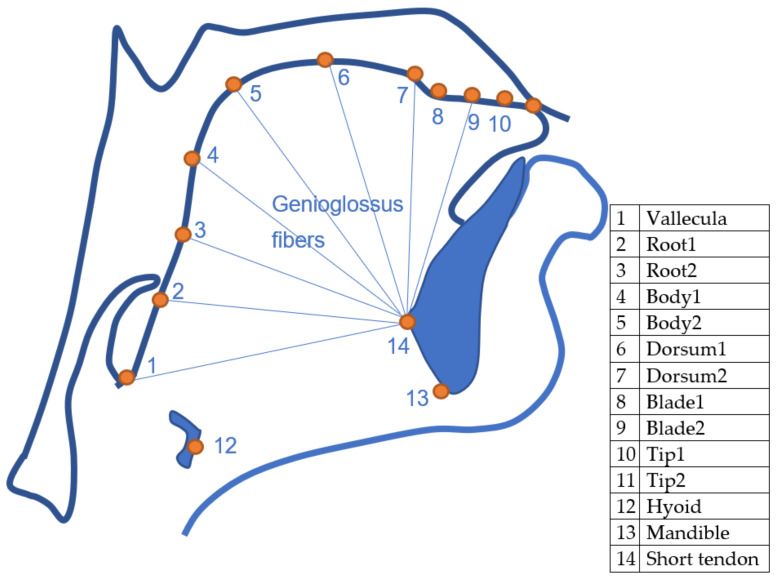
<figcaption>Figure 1: Schematic representation of the knots tracked by DeepLabCut. CC-BY Wrench and Balch-Tomes <span class="citation" data-cites="wrench2024">(<a href="#ref-wrench2024" role="doc-biblioref">Wrench 2024</a>)</span>.</figcaption>
</figure>

Classical ways to analyse tongue contour data obtained from a fan-line system, like SS-ANOVA ([Davidson 2006](#ref-davidson2006); [Chen and Lin 2011](#ref-chen2011)) and Generalised Additive Models using polar coordinates ([Coretta 2018b](#ref-coretta2018c), [n.d.](#ref-coretta2019g)), are not appropriate with DLC-tracked data, due to the tongue contour “curling” onto itself along the root. This is illustrated in <a href="#fig-curl" class="quarto-xref">Figure 2</a>: the plot shows the DLC-tracked points (in black) of the data from a Polish speaker and the traced tongue contours based on the points (see <a href="#sec-gam-vc-coart" class="quarto-xref">Section 2.1</a> for details on the data). The contours clearly curl onto themselves along the root (on the left of the contour). The red smooths represent a LOESS smooth, calculated for Y along X. This approach clearly miscalculates the smooth for the back half of the tongue, simply because there are two Y values for the same X value, and the procedure, in that case, returns something like an average of the two values. Generalised Additive Models (introduced in the following section) work on the same principle and hence would produce the same type of error. Using polar coordinates would not solve the problem: while a fan-line system lends itself easily to using polar coordinates (since the origin of the probe can be used to approximate the origin of the coordinate system), this cannot be done with DLC data because there is, in reality, no single origin in the actual tongue anatomy from which vectors of displacement radiate, that would work for all tracked points.

In [ ]:
dlc_voff_f <- readRDS("data/coretta2018/dlc_voff_f.rds")

dlc_voff_f |> 
  filter(speaker == "pl04") |> 
  ggplot(aes(X, Y)) +
  geom_point(alpha = 0.25) +
  geom_path(aes(group = frame_id), alpha = 0.25) +
  geom_smooth(colour = "red", method = "loess", formula = "y ~ x") +
  coord_fixed() +
  facet_grid(vowel ~ c2) +
  theme(legend.position = "none")

In this tutorial, we introduce two alternative methods to analyse DLC-tracked tongue contour data: Multivariate Generalised Additive Models (<a href="#sec-gam" class="quarto-xref">Section 2</a>) and Multivariate Functional Principal Component Analysis (<a href="#sec-fpca" class="quarto-xref">Section 3</a>). We will present the pros and cons of each method in <a href="#sec-procons" class="quarto-xref">Section 4</a>, but to summarise we are inclined to recommend Multivariate Functional Principal Component Analysis over Multivariate Generalised Additive Models due to the substantial computational overhead and reduced practical utility of the latter over the former.

# Multivariate Generalised Additive Models

Generalised Additive Models (GAMs) are an extension of generalised models that allow flexible modelling of non-linear effects ([Hastie and Tibshirani 1986](#ref-hastie1986); [Wood 2006](#ref-wood2006)). GAMs are built upon smoothing splines functions, the components of which are multiplied by estimated coefficients to reconstruct an arbitrary time-changing curve. For a thorough introduction to GAMs we refer the reader to ([Sóskuthy 2021b](#ref-soskuthy2017a), [2021a](#ref-soskuthy2021); [Pedersen et al. 2019](#ref-pedersen2019); [Wieling 2018](#ref-wieling2018)). Multivariate Generalised Additive Models (MGAMs) are GAMs with more than one outcome variable.

As mentioned in the Introduction, the data tracked by DeepLabCut consists of the position on the horizontal (*x*) and vertical (*y*) axes of fourteen knots. In this tutorial, we will focus on modelling the tongue contour based on the 11 knots from the vallecula to the tongue tip. <a href="#fig-tongue" class="quarto-xref">Figure 3</a> illustrates the reconstructed tongue contour on the basis of the 11 knots: the shown tongue is from the offset of a vowel \[o\] followed by \[t\], uttered by a Polish speaker (see <a href="#sec-gam-vc-coart" class="quarto-xref">Section 2.1</a>).

In [ ]:
dlc_voff_f |> 
  filter(speaker == "pl04", frame_id == 432) |> 
  ggplot(aes(X, Y, group = frame_id)) +
  geom_point() +
  geom_path() +
  coord_fixed() +
  labs(x = "X (mm)", y = "Y (mm)")

The same data is shown in <a href="#fig-tongue-xy" class="quarto-xref">Figure 4</a>, but in a different format. Instead of a Cartesian coordinate system of X and Y values, the plot has knot number on the *x*-axis and X/Y coordinates on the *y*-axis. The X/Y coordinates thus form “trajectories” along the knots. These X/Y trajectories are the ones that can be modelled using MGAMs and Multiple Functional Principal Component Analysis (MFPCA): in both cases, the X/Y trajectories are modelled as two variables changing along knot number. In this section, we will illustrate GAMs applied to the X/Y trajectories along the knots and how we can reconstruct the tongue contour from the modelled trajectories. We will use data from two case studies of coarticulation: vowel consonant (VC) coarticulation based on C place in Italian and Polish, and consonantal articulation of plain vs emphatic consonants in Lebanese Arabic.

In [ ]:
dlc_voff_f |> 
  filter(speaker == "pl04", frame_id == 432) |> 
  dplyr::select(knot, X, Y) |> 
  pivot_longer(c(X,Y)) |> 
  ggplot(aes(knot + 1, value)) +
  geom_point() +
  geom_path() +
  facet_grid(rows = vars(name)) +
  scale_x_continuous(breaks = 1:11) +
  labs(x = "Knot", y = "Position (mm)")

## VC coarticulation

The data of the first case study, Coretta ([2018a](#ref-coretta2018f)), comes from Coretta ([2020b](#ref-coretta2020b)) and have been discussed in Coretta ([2020a](#ref-coretta2020)) (the analysis concerned the position of the tongue root during the duration of vowels followed by voiceless or voiced stops; in this paper we focus on tongue contours at the vowel offset). The materials are /pVCV/ words embedded in a frame sentence (*Dico X lentamente* ‘I say X slowly’ in Italian and *Mówię X teraz* ‘I say X now’ in Polish). In the /pVCV/ words, C was /t, d, k, ɡ/ and V was /a, o, u/ (in each word, the two vowels where identical, so for example *pata, poto, putu*). The data analysed here is from 9 speakers of Italian and 6 speakers of Polish (other speakers were not included due to the difficulty in processing their data with DeepLabCut).

Ultrasound tongue imaging was obtained with the set up by Articulate Assistant Advanced™ (AAA, [Ltd 2011](#ref-ltd2011)). Spline data was extracted using a custom DeepLabCut (DLC) model developed by Wrench and Balch-Tomes ([2022](#ref-wrench2022)). When exporting from AAA™, the data was rotated based on the bite plane, obtained with the imaging of a bite plate ([Scobbie et al. 2011](#ref-scobbie2011)), so that the bite plane is horizontal: this allows for a common coordinate system where vertical and horizontal movement are comparable across speakers. Once the DLC data was imported in R, we manually removed tracking errors and we calculated *z*-scores within each speaker (the difference between the value and the mean, divided by the standard deviation). These steps are documented in the paper’s notebook [Prepare data](notebooks/01_prepare_data.qmd).

The following code chunk reads the filtered data. A sample of the data is shown in <a href="#tbl-dlc-voff" class="quarto-xref">Table 1</a>. <a href="#fig-voff" class="quarto-xref">Figure 5</a> shows the tongue contours for each individual speaker. It is possible to notice clusters of different contours, related to each of the vowels /a, o, u/. <a href="#fig-pl04" class="quarto-xref">Figure 6</a> zooms in on PL04 (Polish): the contours of each vowel are coloured separately, and two panels separate tongue contours taken at the offset of vowels followed by coronal (/t, d/) and velar stops (/k, ɡ/). Crucially, the variation in tongue shape at vowel offset (or closure onset) across vowels contexts is higher in the coronal than in the velar contexts. This is not surprising, giving the greater involvement of the tongue body and dorsum (the relevant articulators of vowel production) in velar than in coronal stops.

In [ ]:
dlc_voff_f <- readRDS("data/coretta2018/dlc_voff_f.rds")

In [ ]:
head(dlc_voff_f |> select(speaker, word, X, Y, knot, knot_label)) |> kable()

In [ ]:
dlc_voff_f |> 
  ggplot(aes(X_z, Y_z, group = frame_id)) +
  geom_path(alpha = 0.25) +
  coord_fixed() +
  facet_wrap(vars(speaker), ncol = 5)

In [ ]:
dlc_voff_f |> 
  filter(speaker == "pl04") |> 
  ggplot(aes(X_z, Y_z, group = frame_id, colour = vowel)) +
  geom_path(alpha = 0.5) +
  coord_fixed() +
  facet_grid(cols = vars(c2_place)) +
  labs(x = "X (z-scores)", "Y (z-scores)")

We can now run a multivariate GAM to model the tongue contours. A multivariate GAM can be fitted by providing model formulae for each outcome variable (in our case, `X_z` and `Y_z`) in a list. For example `list(y ~ s(x), w ~ s(x))` would instruct `mgcv::gam()` to fit a bivariate GAM with the two outcome variables `y` and `w`. The required family is `mvn` for “multivariate normal”: `mvn(d = 2)` indicates a bivariate family (a multivariate family with two dimensions, i.e. two outcome variables). In the model below, we are fitting a multivariate GAM to the *z*-scored X and Y coordinates. For both outcome variables, we include a smooth over knot (`s(knot, ...)`) with a `by` variable `vow_place_lang`: this variable is built from an interaction of vowel, place and language.[1] We set `k` to 5: this will usually be sufficient for X/Y coordinates of tongue contours, since they are by nature not very “wiggly” (which would require a higher `k`). We also include a factor smooth over knot for speaker (the equivalent of a non-linear random effect) with `s(knot, speaker, ...)`: since language is a between-speaker variable, we use `vow_place` as the `by` variable (`vow_place` is the interaction of vowel and place).

[1] Note that interactions between categorical variables in the classical sense are not possible in GAMs. Instead, one can approximate interactions by creating an “interaction variable”, which is simply a variable where the values of the interacting variables are pasted together.

In [ ]:
library(mgcv)

voff_gam <- gam(
  list(
    X_z ~ vow_place_lang +
      s(knot, by = vow_place_lang, k = 5) +
      s(knot, speaker, by = vow_place, bs = "fs", m = 1),
    Y_z ~ vow_place_lang +
      s(knot, by = vow_place_lang, k = 5) +
      s(knot, speaker, by = vow_place, bs = "fs", m = 1)
  ),
  data = dlc_voff_f,
  family = mvn(d = 2)
)

In [ ]:
library(mgcv)

Loading required package: nlme


Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

The model summary is not particular insightful. What we are normally interested in is the reconstructed tongue contours and in which locations they are similar of different across conditions. To the best of our knowledge, there isn’t a straightforward way to compute sensible measures of comparison, given the multidimensional nature of the model (i.e., only one or the other outcome can be inspected at a time; moreover, difference smooths, like in Sóskuthy ([2021b](#ref-soskuthy2017a)) and Wieling ([2018](#ref-wieling2018)), represent the difference of the *sum* of the outcome variables, rather than each outcome separately, Michele Gubian pers. comm.) We thus recommend to plot the predicted tongue contours and base any further inference on impressionistic observations on such predicted contours. Alas, there is also no straightforward way to plot predicted tongue contours, but to extract the predictions following a step-by-step procedure, like the one illustrated in the following paragraphs.

First off, one has to create a grid of predictor values to obtain predictions for. We do this with `expand_grid()` in the following code chunk. We start with unique values of `speaker`, `vow_place` and `knot` (rather than just using integers for the knots, we predict along increments of 0.1 from 0 to 10 for a more refined tongue contour). We then create the required column `vow_place_lang` by appending the language name based on the speaker ID. Note that all variables included as predictors in the model must be included in the prediction grid.

In [ ]:
# Create a grid of values to predict for
frame_voff <- expand_grid(
  # All the speakers
  speaker = unique(dlc_voff_f$speaker),
  # All vowel/place combinations
  vow_place = unique(dlc_voff_f$vow_place),
  # Knots from 0 to 10 by increments of 0.1
  # This gives us greater resolution along the tongue contour than just using 10 knots
  knot = seq(0, 10, by = 0.1)
) |> 
  mutate(
    vow_place_lang = case_when(
      str_detect(speaker, "it") ~ paste0(vow_place, ".Italian"),
      str_detect(speaker, "pl") ~ paste0(vow_place, ".Polish")
    )
  )

With the prediction grid `frame_voff` we can now extract predictions from the model `voff_gam` with `predict()`. This function requires the GAM model object (`voff_gam`) and the prediction grid (`frame_off`). We also obtain the standard error of the prediction which we will use to calculate Confidence Intervals in the next step. Since we have used factor smooths for speaker, we now have to manually exclude these smooths from the prediction to obtain a “population” level prediction. We do this by listing the smooths to be removed in `excl`: note that the smooths must be named as they are in the summary of the model, so always check the summary to ensure you list all of the factor smooths. Finally, we rename the columns with the name of the outcome variables.

In [ ]:
# List of factor smooths, to be excluded from prediction
excl <- c(
  "s(knot,speaker):vow_placea.coronal",
  "s(knot,speaker):vow_placeo.coronal",
  "s(knot,speaker):vow_placeu.coronal",
  "s(knot,speaker):vow_placea.velar",
  "s(knot,speaker):vow_placeo.velar",
  "s(knot,speaker):vow_placeu.velar",
  "s.1(knot,speaker):vow_placea.coronal",
  "s.1(knot,speaker):vow_placeo.coronal",
  "s.1(knot,speaker):vow_placeu.coronal",
  "s.1(knot,speaker):vow_placea.velar",
  "s.1(knot,speaker):vow_placeo.velar",
  "s.1(knot,speaker):vow_placeu.velar"
)

# Get prediction from model voff_gam
voff_gam_p <- predict(voff_gam, frame_voff, se.fit = TRUE, exclude = excl) |>
  as.data.frame() |>
  as_tibble()

# Rename columns
colnames(voff_gam_p) <- c("X", "Y", "X_se", "Y_se")

Now we have to join the prediction in `voff_gam_p` with the prediction frame, so that we have all the predictor values in the same data frame. We do so here with `bind_cols()` from the dplyr package. Note that `voff_gam_p` contains predictions for each level of the factor smooths, despite these being excluded from prediction. If you inspect the predictions for different speakers, you will find that they are the same for the same levels of `vow_place_lang`: this is because the effects of the factor smooths were removed, so `speaker` has no effect on the predicted values. This means that you can pick any Italian and Polish speaker in the predicted data frame. We do so by filtering with `filter(speaker %in% c("it01", "pl02"))`, but any other speaker would lead to the same output. We also calculate the lower and upper limits of 95% Confidence intervals (CI) for each coordinate. Note that you should interpret these CI with a grain of salt, because they are not truly multivariate, but rather represent the CI on each coordinate axis independently.

In [ ]:
voff_gam_p <- bind_cols(frame_voff, voff_gam_p) |> 
  # pick any Italian and Polish speaker, random effects have been removed
  filter(speaker %in% c("it01", "pl02")) |> 
  # Calculate 95% CIs of X and Y
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  # Separate column into individual variables, for plotting later
  separate(vow_place_lang, c("vowel", "place", "language"))

<a href="#fig-voff-pred" class="quarto-xref">Figure 7</a> and <a href="#fig-voff-ci" class="quarto-xref">Figure 8</a> show the predicted tongue contours based on the `voff_gam` model, without and with 95% CIs respectively. As mentioned earlier, there isn’t a straightforward way to obtain any statistical measure of the difference between the contours on the multivariate plane, so we must be content with the figure.

In [ ]:
voff_gam_p |> 
  ggplot(aes(X, Y, colour = vowel)) +
  geom_point(alpha = 0.5) +
  facet_grid(cols = vars(place), rows = vars(language)) +
  coord_fixed() +
  labs(
    x = "X (z-scores)",
    y = "Y (z-scores)"
  )

In [ ]:
voff_gam_p |> 
  group_by(place, vowel, language) |> 
  mutate(
    Y_lo = ifelse(Y_lo > min(Y), Y_lo, NA),
    X_hi = ifelse(X_hi < max(X), X_hi, NA),
  ) |> 
  ggplot(aes(X, Y, colour = vowel)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.5) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.5) +
  geom_point(size = 1, alpha = 0.75) +
  scale_color_brewer(type = "qual", palette = "Dark2") +
  coord_fixed() +
  facet_grid(cols = vars(place), rows = vars(language)) +
  theme_light() +
  theme(legend.position = "bottom")

(`geom_errorbarh()`).

## Emphaticness

The second case study is about consonant “emphaticness” in Lebanese Arabic. The data is from Sakr ([2025](#ref-sakr2025)). \[XXX TODO GEORGE description of the data, including a brief explanation of the LebAr context\]. The second case study is about consonant “emphaticness” in Lebanese Arabic.

Lebanese Arabic is a variety of Arabic primarily spoken in Lebanon, where it is in constant contact with a number of Indo-European languages (primarily English and French, as vectors of education and business, see eg. [Shaaban and Ghaith 1999](#ref-shaaban1999)), as well as the written standard form of Arabic known as Modern Standard Arabic (MSA). The relationship between Lebanese Arabic (LA) and MSA in Lebanon is one of diglossia (see eg. [Lian 2022](#ref-lian2022)), where LA is spoken in most contexts, but not written, and MSA is the written variety, and therefore also primarily used for legal and official purposes.

Emphasis is a phonologically contrastive feature of Semitic languages. In most varieties of Arabic, it is usually reported to be realised as pharyngealisation ([Sakr 2023](#ref-sakr2023); [J. Al-Tamimi 2017](#ref-al-tamimi2017); [Zeroual, Esling, and Hoole 2011](#ref-zeroual2011); [Watson 2002](#ref-watson2002)) with some variation depending on phonological context ([Sakr 2025](#ref-sakr2025); [F. Al-Tamimi and Heselwood 2011](#ref-al-tamimi2011)) or on sociolinguistic factors ([Khattab, Al-Tamimi, and Heselwood 2006](#ref-khattab2006)). Older sources instead report the secondary place of articulation as being the velum (see eg. [Obrecht 1968](#ref-obrecht1968); [Nasr 1959](#ref-nasr1959)) or the uvula (see eg. [Bin-Muqbil 2006](#ref-bin-muqbil2006); [Zawaydeh 1999](#ref-zawaydeh1999); [Ghazeli 1977](#ref-ghazeli1977)). Whatever the specifics of this secondary place of articulation, the literature (see among others [Sullivan 2017](#ref-sullivan2017); [El-Khaissi 2015](#ref-el-khaissi2015); [Elhij’a 2012](#ref-elhija2012); [Alorifi 2008](#ref-alorifi2008)) additionally suggests the occurrence of a loss of emphasis in Lebanese, or more generally Levantine or Western dialects of Arabic, likely as a result of the contact with the Indo-European languages mentioned above.

It is against this background, and as part of efforts to document the precise place of secondary articulation of emphasis in Lebanese Arabic, as well as to document whether or not emphasis has, indeed, been lost in the variety, that the data used here (from [Sakr 2025](#ref-sakr2025)) was collected. It consists of UTI recordings, by 5 participants, of CVb stimuli. The onset was either an emphatic or an unemphatic (‘plain’), voiced or voiceless, alveolar, plosive or fricative /t, ṭ, d, ḍ, s, ṣ, z, ẓ/; when talking about a plain/emphatic pair, we denote them /T, D, S, Z/. The nucleus was one of five vowel qualities (see [Sakr 2019](#ref-sakr2019)) present in Lebanese, which we will denote with /A, E, I, O, U/ to signal that these are neither to be taken as phonemes or exact phonetic realisations. The coda was the voiced bilabial plosive /b/.

Each recording consisted of four stimuli in randomized order, covering forty syllables, in five repetitions; for a total of 1000 recordings. The subset of the data used here is from 35ms before consonant offset, defined as the burst for the plosives and as the end of the frication noise for the fricatives.

In [ ]:
dlc_emph_f <- readRDS("data/sakr2025/dlc_emph_f.rds")

Since the procedure to fit and plot MGAMs is the same as the one presented in <a href="#sec-gam-vc-coart" class="quarto-xref">Section 2.1</a>, we won’t be showing the code in this section, but readers can find the code in the Article Notebook, at <https://stefanocoretta.github.io/mv_uti/index-preview.html>.

In [ ]:
library(mgcv)

fi <- "data/cache/emph_gam.rds"

if (file.exists(fi)) {
  emph_gam <- readRDS(fi)
} else {
  emph_gam <- gam(
    list(
      X_z ~ vow_emph +
        s(knot, by = vow_emph, k = 5) +
        s(knot, participant, by = vow_emph, bs = "fs", m = 1, k = 5),
      Y_z ~ vow_emph +
        s(knot, by = vow_emph, k = 5) +
        s(knot, participant, by = vow_emph, bs = "fs", m = 1, k = 5)
    ),
    data = dlc_emph_f,
    family = mvn(d = 2)
  )
  
  saveRDS(emph_gam, fi)
}

In [ ]:
frame_emph <- expand_grid(
  participant = unique(dlc_emph_f$participant),
  vow_emph = unique(dlc_emph_f$vow_emph),
  knot = seq(0, 10, by = 0.1)
)

excl <- c(
  "s(Knot,participant):vow_emphA.Emphatic",
  "s(Knot,participant):vow_emphE.Emphatic",
  "s(Knot,participant):vow_emphI.Emphatic",
  "s(Knot,participant):vow_emphO.Emphatic",
  "s(Knot,participant):vow_emphU.Emphatic",
  "s.1(Knot,participant):vow_emphA.Emphatic",
  "s.1(Knot,participant):vow_emphE.Emphatic",
  "s.1(Knot,participant):vow_emphI.Emphatic",
  "s.1(Knot,participant):vow_emphO.Emphatic",
  "s.1(Knot,participant):vow_emphU.Emphatic",
  "s(Knot,participant):vow_emphA.Plain",
  "s(Knot,participant):vow_emphE.Plain",
  "s(Knot,participant):vow_emphI.Plain",
  "s(Knot,participant):vow_emphO.Plain",
  "s(Knot,participant):vow_emphU.Plain",
  "s.1(Knot,participant):vow_emphA.Plain",
  "s.1(Knot,participant):vow_emphE.Plain",
  "s.1(Knot,participant):vow_emphI.Plain",
  "s.1(Knot,participant):vow_emphO.Plain",
  "s.1(Knot,participant):vow_emphU.Plain"
)

emph_gam_p <- predict(emph_gam, frame_emph, se.fit = TRUE, exclude = excl) |>
  as.data.frame() |>
  as_tibble()
colnames(emph_gam_p) <- c("X", "Y", "X_se", "Y_se")

emph_gam_p <- bind_cols(frame_emph, emph_gam_p) |> 
  # pick any speaker, random effects have been removed
  filter(participant == "Sak") |> 
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  separate(vow_emph, c("vowel", "emph"))

<a href="#fig-emph-ci" class="quarto-xref">Figure 9</a> shows the predicted tongue contours of emphatic and plain consonants, split by following vowel. First, the following vowel exercises an appreciable amount of coarticulation on the preceding consonant. The vowel-induced coarticulation seem to be modulating how the emphatic vs plain distinction is implemented (or not): in the context of the vowels /A, O, U/, emphatic consonants are produced with a retracted body and root, indicating pharyngealisation. On the other hand, in the context of the front vowels /E, I/, there is visibly less distinction between emphatic and plain consonants, which is virtually absent in /E/. However, when plotting the predictions for the different vocalic contexts and different speakers, the picture becomes more complex.

In [ ]:
emph_gam_p |> 
  ggplot(aes(X, Y, colour = emph)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.25) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.25) +
  geom_point(size = 1, alpha = 0.75) +
  scale_color_brewer(type = "qual", palette = "Dark2") +
  coord_fixed() +
  facet_grid(cols = vars(vowel)) +
  theme_light() +
  theme(legend.position = "bottom")

In [ ]:
emph_gam_p_2 <- predict(emph_gam, frame_emph, se.fit = TRUE) |>
  as.data.frame() |>
  as_tibble()
colnames(emph_gam_p_2) <- c("X", "Y", "X_se", "Y_se")

emph_gam_p_2 <- bind_cols(frame_emph, emph_gam_p_2) |>
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  separate(vow_emph, c("vowel", "emph"))

In <a href="#fig-emph-part" class="quarto-xref">Figure 10</a>, predictions have been calculated for individual speakers (see Article Notebook online, linked above, for the code). First, there is a good deal of individual variation: some speakers show a clear differentiation of the tongue shape in emphatic and plain consonants, while in other speakers the difference is less obvious. FAK produced emphatic and plain consonants with virtually the same tongue shape. Just to pick another example, BAR velarised rather than pharyngealised the emphatic consonants followed by /I/, while BAY pharyngealised them. Plotting predictions of individual speakers can reveal idiosyncratic patterns which are not visible when plotting overall predictions.

In [ ]:
emph_gam_p_2 |> 
  ggplot(aes(X, Y, colour = emph)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.5) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.5) +
  facet_grid(rows = vars(participant), cols = vars(vowel)) +
  coord_fixed()

# Multivariate Functional Principal Component Analysis

Principal Component Analysis (PCA) is a dimensionality reduction technique. For an introduction to PCA we recommend Kassambara ([2017](#ref-kassambara2017a)). Functional PCA (FPCA) is an extension of PCA: while classical PCA works by finding common variance in a set of variables (and by reducing the variables to Principal Components that explain that common variance), FPCA is a PCA applied to a functional representation of varying numerical variables ([Gubian et al. 2019](#ref-gubian2019); [Gubian, Pastätter, and Pouplier 2019](#ref-gubian2019a); [Gubian 2024](#ref-gubian2024)): a typical example is time-series data, with a variable changing over time. The trajectory of the time-varying variable is encoded into a function with a set of coefficients and the values of those coefficients are submit to PCA. When more than one time-varying variable is needed, this is where Multivariate FPCA (MFPCA) come in ([Gubian 2024](#ref-gubian2024)).

MFPCA is an FPCA applied to two or more varying variables. Note that the variable does not have to be *time*-varying. The variation can be on any linear variable: in the case of DLC-tracked UTI data, the variation happens along the knot number. Look back at <a href="#fig-tongue-xy" class="quarto-xref">Figure 4</a>: the two varying variables are the X and Y coordinates, which are varying along the DLC knots. As with MGAMs, it is these two varying trajectories that are submitted to MFPCA.

## VC coarticulation

We will apply Multivariate Functional Principal Component Analysis (MFPCA) to the data introduced in <a href="#sec-gam-vc-coart" class="quarto-xref">Section 2.1</a>. The following code has been adapted from Gubian ([2024](#ref-gubian2024)). The packages below are needed to run MFPCA (except landmarkregUtils, they are available on CRAN).

In [ ]:
library(fda)

Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: pcaPP

Loading required package: RCurl


Attaching package: 'RCurl'

The following object is masked from 'package:tidyr':

    complete

Loading required package: deSolve


Attaching package: 'fda'

The following object is masked from 'package:graphics':

    matplot

The following object is masked from 'package:datasets':

    gait


Attaching package: 'funData'

The following object is masked from 'package:ggplot2':

    ggplot

The following object is masked from 'package:stats':

    integrate

The format required to work through MFPCA is a “long” format with one column containing the coordinate labels (*x* or *y* coordinate) and another with the coordinate values. We can easily pivot the data with `pivot_longer()`. Note that we are using the *z*-scored coordinate values (`X_z` and `Y_z`). If you are not unsure about what the code in this section, it is always useful to inspect intermediate and final output.

In [ ]:
dlc_voff_long <- dlc_voff_f |> 
  # Select relevant columns
  dplyr::select(X_z, Y_z, frame_id, knot, vowel, c2_place, language, speaker) |> 
  # Pivot data to longer format. Saves coordinate labels to column `dim`
  pivot_longer(c(X_z, Y_z), names_to = "dim")

In the second step, we create a `multiFunData` object: this is a special type of list object, with the observations of the two coordinates (`X_z` and `Y_z`) as two matrices of dimension $N \cdot 11$, where $N$ is the number of tongue contours and $11$ is for the 11 knots returned by DLC. Three columns in the data are used to create the `multiFunData` object: one column with the id of each contour (in our data, `frame_id`), a time or series column (`knot`) and the column with the coordinate values (`value`).

In [ ]:
curves_fun_2d <- lapply(
  c("X_z", "Y_z"),
  function(y) {
    long2irregFunData(
      dlc_voff_long |> filter(dim == {{y}}),
      # Tongue contour ID
      id = "frame_id",
      # Knot column
      time = "knot",
      # X/Y coordinate values
      value = "value"
    ) |> 
    as.funData()
  }
) |> 
  multiFunData()

Once we have our `multFunData` object, we can use the `MFPCA()` function to compute an MFPCA. In this tutorial we will compute the first two PCs, but you can compute up to $K-1$ PCs where $K$ is the number of DLC knots in the data.

In [ ]:
# Number of PC to compute
n_pc <- 2

# Compute MFPCA
mfpca <- MFPCA(
  curves_fun_2d,
  M = n_pc,
  uniExpansions = list(list(type = "uFPCA"), list(type = "uFPCA"))
)

We can quickly calculate the proportion of explained variance of each PC with the following code. PC1 and PC2 together explain almost 100% of the variance in our data. The higher the variance explained, the better the variance patterns in the data are captured.

In [ ]:
# Proportion of explained variance
mfpca$values  / sum(mfpca$values)

[1] 0.7108713 0.2891287

The best way to assess the effect of the PC scores on the shape of the tongue contours is to plot the predicted tongue contours based on a set of representative PC scores. In order to be able to plot the predicted contours, we need to calculate them from the MFPCA object. Gubian suggests plotting predicted curves at score intervals based on fractions of the scores standard deviation. This is what the following code does.

In [ ]:
# Get the PC score SD
sd_fun <- sqrt(mfpca$values)

# PC curves to be plotted
pc_curves <- expand_grid(
  PC = 1:n_pc,
  dim = 1:2,
  # Set the SD fraction, from -1 SD to +1 SD, with increments by 0.25
  sd_frac = seq(-1, 1, by = 0.25)
) |>
  group_by(PC, dim, sd_frac) |>
  # We can now calculate the predicted contour with funData2long1().
  # reframe() is needed because the funData2long1() function returns a data frame
  # the has more rows than the original.
  reframe(
    funData2long1(
      mfpca$meanFunction[[dim]] +
        sd_frac * sd_fun[PC] * mfpca$functions[[dim]][PC],
      time = "knot", value = "value"
    )
  ) |> 
  # We relabel the dimensions
  mutate(
    dim = factor(dim, levels = c(2, 1), labels = c('Y_z', 'X_z'))
  )

The created data frame `pc_curves` has the predicted values of the X and Y coordinates *along the knots*. This is the same structure as <a href="#fig-tongue-xy" class="quarto-xref">Figure 4</a>, with the knot number on the *x*-axis and the coordinates on the *y*-axis. Of course, what we are after is the X/Y plot of the tongue contours, rather than the knot/coordinate plot as needed to fit an MFPCA. For the sake of clarity, we first plot the predicted curves for X and Y separately. <a href="#fig-pc-curves" class="quarto-xref">Figure 11</a> shows these. The plot is composed of four panels: the top two are the predicted curves along knot number for the Y coordinates (based on PC1 in the left panel and PC2 in the right panel). Interpreting the effect of the PCs on the X and Y coordinates separately allows one to observe vertical (Y coordinate) and horizontal (X coordinate) differences in tongue position independently. However, note that the vector of muscle contractions in the tongue are not simply along a vertical/horizontal axis ([Honda 1996](#ref-honda1996); [Wrench 2024](#ref-wrench2024)). Looking at a full tongue contour (in an X/Y coordinates plot) will generally prove to be more straightforward.

In [ ]:
pc_curves |> 
  ggplot(aes(
    x = knot, y = value, group = sd_frac, color = sd_frac
  )) +
  geom_line() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_grid(
    cols = vars(PC), rows = vars(dim),
    scales = "free_y",
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  labs(color = expression(frac(s[k], sigma[k]))) +
  geom_line(
    data = pc_curves |> filter(sd_frac == 0),
    color = 'black', linewidth = 1.2
  )

In order to plot tongue contours in the X/Y coordinate system, we simply need to pivot the data to a wider format.

In [ ]:
pc_curves_wide <- pc_curves |> 
  pivot_wider(names_from = dim)

<a href="#fig-contours" class="quarto-xref">Figure 12</a> plots the predicted contours based on the the PC scores (specifically, fractions of the standard deviation of the PC scores). The *x* and *y*-axes correspond to the X and Y coordinates of the tongue contour, with the effect of PC1 in the left panel and the effect of PC2 in the right panel. A higher PC1 score (green lines in the left panel) suggest a lowering of the tongue body/dorsum and raising of the tongue tip. Since the data contains velar and coronal consonants, we take this to be capturing the velar/coronal place of articulation effect. A higher PC2 score (green lines in the right panel) corresponds to an overall higher tongue position. Considering that the back/central vowels /a, o, u/ are included in this data set, we take PC2 to be related with the effect of vowel on the tongue shape at closure onset.

In [ ]:
pc_curves_wide |> 
  ggplot(aes(x = X_z, y = Y_z, group = sd_frac, color = sd_frac)) +
  geom_path() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_wrap(
    vars(PC),
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  coord_fixed()

Given the patterns in <a href="#fig-contours" class="quarto-xref">Figure 12</a>, we can expect to see differences in PC2 scores based on the vowel if there is VC coarticulation. We can obtain the PC scores of each observation in the data with the following code.

In [ ]:
pc_scores <- mfpca$scores |>
  `colnames<-`(paste0("PC", 1:n_pc)) |>
  as_tibble() |>
  bind_cols(dlc_voff_long |> distinct(frame_id, vowel, c2_place, language))

<a href="#fig-pc-scores" class="quarto-xref">Figure 13</a> plots PC scores by language (rows), consonant place (columns) and vowel (colour). Both in Italian and Polish, we can observe a clear coarticulatory effect of /u/ on the production of coronal stops (and perhaps minor differences in /a/ vs /o/). On the other hand, the effect of vowel in velar stops seems to be minimal, again in both languages. This is not entirely surprising, since while coronal stops allow for adjustments of (and coarticulatory effect on) the tongue body, velar stops do not since it is precisely the tongue body/dorsum that is raised to produce the velar closure.

In [ ]:
pc_scores |> 
  filter(PC2 < 0.5) |>
  ggplot(aes(x = PC1, y = PC2, color = vowel)) +
  geom_point() +
  stat_ellipse() +
  facet_grid(cols = vars(c2_place), rows = vars(language)) +
  scale_color_brewer(palette = "Dark2")

Once one has established which patterns each PC is capturing, PC scores can be submitted to further statistical modelling, like for example regression models where the PC scores are outcome variables and several predictors are include to assess possible differences in PC scores.

## Emphaticness

In this section we will run an MFPCA analysis on the Lebanese Arabic data. Since the procedure is the same as in the previous section, the code will not be shown here, but can be viewed in the Article Notebook, at <https://stefanocoretta.github.io/mv_uti/index-preview.html>.

In [ ]:
dlc_emph_long <- dlc_emph_f |> 
  pivot_longer(c(X_z, Y_z), names_to = "dim") |> 
  group_by(dim, participant) |> 
  mutate(
    value = (value - mean(value)) / sd(value)
  ) |> 
  ungroup()

In [ ]:
curves_fun_2d <- lapply(
  c("X_z", "Y_z"),
  function(y) {
    long2irregFunData(
      dlc_emph_long |> filter(dim == {{y}}),
      # Tongue contour ID
      id = "frame_id",
      # Knot column
      time = "knot",
      # X/Y coordinate values
      value = "value"
    ) |> 
    as.funData()
  }
) |> 
  multiFunData()

In [ ]:
# Number of PC to compute
n_pc <- 2

# Compute MFPCA
mfpca <- MFPCA(
  curves_fun_2d,
  M = n_pc,
  uniExpansions = list(list(type = "uFPCA"), list(type = "uFPCA"))
)

In [ ]:
# Proportion of explained variance
mfpca$values  / sum(mfpca$values)

[1] 0.7309506 0.2690494

In [ ]:
# Get the PC score SD
sd_fun <- sqrt(mfpca$values)

# PC curves to be plotted
pc_curves <- expand_grid(
  PC = 1:n_pc,
  dim = 1:2,
  # Set the SD fraction, from -1 SD to +1 SD, with increments by 0.25
  sd_frac = seq(-1, 1, by = 0.25)
) |>
  group_by(PC, dim, sd_frac) |>
  # We can now calculate the predicted contour with funData2long1().
  # reframe() is needed because the funData2long1() function returns a data frame
  # the has more rows than the original.
  reframe(
    funData2long1(
      mfpca$meanFunction[[dim]] +
        sd_frac * sd_fun[PC] * mfpca$functions[[dim]][PC],
      time = "knot", value = "value"
    )
  ) |> 
  # We relabel the dimensions
  mutate(
    dim = factor(dim, levels = c(2,1), labels = c('Y_z', 'X_z'))
  )

In [ ]:
pc_curves |> 
  ggplot(aes(
    x = knot, y = value, group = sd_frac, color = sd_frac
  )) +
  geom_line() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_grid(
    cols = vars(PC), rows = vars(dim),
    scales = "free_y",
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  labs(color = expression(frac(s[k], sigma[k]))) +
  geom_line(
    data = pc_curves |> filter(sd_frac == 0),
    color = 'black', linewidth = 1.2
  )

In [ ]:
pc_curves_wide <- pc_curves |> 
  pivot_wider(names_from = dim)

<a href="#fig-emph-curves-wide" class="quarto-xref">Figure 15</a> illustrates the reconstructed tongue contours (taken from 35 ms before the CV boundary) in Lebanese Arabic, based on the MFPCA. PC1 captures the low-back/high-front diagonal movement. PC2, on the other hand, seems to be restricted to high/low movement at the back of the oral cavity. Emphatic consonants, if produced with a constricted pharynx (i.e. pharyngealised), should have a lower PC1. If on the other hand they are produced with a raised tongue dorsum (i.e. velarised), they should have a lower PC2 (lower PC scores are in purple in <a href="#fig-emph-curves-wide" class="quarto-xref">Figure 15</a>).

In [ ]:
pc_curves_wide |> 
  ggplot(aes(x = X_z, y = Y_z, group = sd_frac, color = sd_frac)) +
  geom_path() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_wrap(
    vars(PC),
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  coord_fixed()

In [ ]:
pc_scores <- mfpca$scores |>
  `colnames<-`( paste0("PC", 1:n_pc)) |>
  as_tibble() |>
  bind_cols(dlc_emph_long |> distinct(frame_id, emph, vowel, participant))

<a href="#fig-emph-speakers" class="quarto-xref">Figure 16</a> plots the PC scores for each vowel, emphaticness and speaker combination. Points are coloured based on emphaticness: emphatic in green and plain in orange. This figure illustrates well how the PC scores can capture individual variation: some speakers show clear separation of emphatic and plain tokens, while others do not. In most cases, PC1 is doing the heavy lifting of distinguishing emphatic and plain: recall that PC1 captures the front-high/back-low diagonal; a low PC1 indicates tongue dorsum and root backing, in other words pharyngealisation. Indeed, PC1 tends to be lower in emphatic tokens in several speakers, like Bar, Bay, Mro and Sak, especially with the vowels /A, O, U/. On the other hand, Bar’s emphatic and plain tokens for vowels /E, I/ do not show a PC1 difference, but rather a PC2 difference: PC2 captures tongue dorsum/body raising, hence indicating velarisation. It is possible that in Bar’s productions of emphatic consonants followed by /E, I/ the distinction with plain is produced by velarisation, compared to the pharyngealisation of emphatic consonants followed by /A, O, U/. Velarisation, rather than pharyngealisation, in the /E, I/ contexts makes sense given that the tongue root has to be front in the production of those vowels.

In [ ]:
pc_scores |> 
  ggplot(aes(x = PC1, y = PC2, colour = emph, label = vowel)) +
  geom_point(alpha = 0.5) +
  scale_color_brewer(palette = "Dark2") +
  stat_ellipse() +
  facet_grid(cols = vars(participant), rows = vars(vowel))

<a href="#fig-emph-pc1" class="quarto-xref">Figure 17</a> and <a href="#fig-emph-pc2" class="quarto-xref">Figure 18</a> illustrate one way to plot the PC scores individually for PC1 and PC2. We won’t include here a full description of the plots, since they should be self-explanatory, but we flag to the reader that these type of plots can be helpful in illustrating specific patterns in PC1 or PC2.

In [ ]:
pc_scores |> 
  ggplot(aes(vowel, PC1, colour = emph)) +
  geom_jitter(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.25) +
  scale_color_brewer(palette = "Dark2") +
    facet_wrap(vars(participant))

In [ ]:
pc_scores |> 
  ggplot(aes(vowel, PC2, colour = emph)) +
  geom_jitter(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.25) +
  scale_color_brewer(palette = "Dark2") +
    facet_wrap(vars(participant))

Finally, it will usually be helpful to reconstruct the predicted tongue contours of specific context. For example, we might be interested in showing the average tongue contours for emphatic and plain consonant followed by each of the five vowels in the data. This is shown in <a href="#fig-vow-emph" class="quarto-xref">Figure 19</a>. In order to obtain the reconstructed contours, we first need to calculate mean PC scores for each vowel. This can be done through the following code. We recommend to inspect the `pc_scores_mean` object.

In [ ]:
pc_scores_mean <- pc_scores |>
  # Group by variables based on which we want to obtain mean values.
  group_by(vowel, emph) |> 
  # Sumarise data to obtain means
  summarise(
    PC1 = mean(PC1),
    PC2 = mean(PC2),
    .groups = "drop"
  ) |> 
  # Add "dimensions", i.e. X and Y coordinates
  mutate(
    dim = list(c(1, 2))
  ) |> 
  # Unnes the dim column
  unnest(dim)

The following code calculates the reconstructed tongue contours based on both PC1 and PC2. One could also calculate the reconstructed contours at factions of the standard deviation of the scores if one wished so, like it was done above.

In [ ]:
pc_curves_2 <- pc_scores_mean |> 
  group_by(dim, vowel, emph) |>
  # We can now calculate the predicted contour with funData2long1().
  # reframe() is needed because the funData2long1() function returns a data frame
  # the has more rows than the original.
  reframe(
    funData2long1(
      mfpca$meanFunction[[dim]] +
        # We add PC1
        PC1 * mfpca$functions[[dim]][1] +
        # and we add PC2 as well
        PC2 * mfpca$functions[[dim]][2],
      time = "knot", value = "value"
    )
  ) |> 
  # We relabel the dimensions
  mutate(
    dim = factor(dim, levels = c(2,1), labels = c('Y_z', 'X_z'))
  ) |> 
  pivot_wider(names_from = dim, values_from = value)

Finally, <a href="#fig-vow-emph" class="quarto-xref">Figure 19</a> plots the reconstructed contours. Based on this figure, we do find pharyngealisation in emphatic consonants followed by /A, O, U/ on average, while pharyngealisation is absent in the context of /E, I/.

In [ ]:
pc_curves_2 |> 
  ggplot(aes(X_z, Y_z, colour = emph)) +
  geom_path() +
  facet_wrap(vars(vowel))

# Advantages and disadvantages

Both Multivariate GAMs and FPCA are a useful way to model DLC-tracked ultrasound tongue imaging data. However, each possesses advantages and disadvantages.

Multivariate GAMs can model tongue contours in specific contexts and combinations thereof, like different vowels, consonant, prosodic contexts and so on. The rather complex model structure required to fit multivariate GAMs to tongue data comes at a computational cost and interpretative cost. Computationally, multivariate GAMs can take hours to estimate even the most simple models. Interpretationally, comparing different tongue contours quantitatively based on the output of a multivariate GAM is non-trivial, given that the tongue contour is in fact a curve reconstructed from the smooths of the X and Y coordinates along knot (in other words, the model does not model tongue contours directly). Moreover, there is no straightforward way to use traditional methods to assess (frequentist) statistical significance. From a practical point of view, a multivariate GAM ends up being a mathematically complex way of obtaining a sort of average tongue contour.

Multivariate FPCA, on the other hand, are computationally efficient. Even with very large data sets, the computation of Principal Components is relatively quick. Moreover, the obtained PCs can be interpreted straightforwardly by plotting the effect of changing the PC score on the reconstructed tongue contour (as we did for example in <a href="#fig-contours" class="quarto-xref">Figure 12</a>). One possible disadvantage of multivariate FPCA is that it is usually not known what type of variation each obtained PC captures. This is illustrated in the two case studies in <a href="#sec-fpca" class="quarto-xref">Section 3</a>. In the VC coarticulation data, PC1 corresponded to the coronal/velar difference in consonants, while PC2 to the difference in vowel. In the emphaticness data, PC1 captured the low-back/high-front diagonal movement, while PC2 to the high/low movement at the back of the oral cavity. In other words, until one has run the MPFCA, one does not know what PC will correspond to which axis of differences and whether the PCs will capture relevant difference at all (it can happen that the variation one is after is so minimal relative to other, more substantial cases of variation, that it will not be captures at all). It is possible that qualitatively homogeneous data sets might return PCs that have the same or very similar interpretation, but this has not been systematically tested Honda ([1996](#ref-honda1996)).

Another advantage of MFPCA is that, provided that the PCs have captured relevant characteristics, the PCs can be submitted to further modelling using regression with the inclusion of relevant predictors (like different categorical variables of interest). We have not done so in this tutorial to keep the scope and length of the tutorial manageable, but both case studies presented in <a href="#sec-fpca" class="quarto-xref">Section 3</a> are amenable to such follow-up analysis.

Based on the advantages and disadvantages of each of multivariate GAMs and FPCA, we suggest researchers to use MFPCA as the preferred and default approach to analyse DLC-tracked tongue contour data and to resort to multivariate GAMs if MFPCA fails to capture relevant variation.

# Conclusions

TBA

# References

Alorifi, Fawzi S. 2008. “Automatic Identification of Arabic Dialects Using Hidden Markov Models.” PhD thesis.

Al-Tamimi, Feda, and Barry Heselwood. 2011. “Nasoendoscopic, Videofluoroscopic and Acoustic Study of Plain and Emphatic Coronals in Jordanian Arabic.” *Instrumental Studies in Arabic Phonetics* 319: 165191.

Al-Tamimi, Jalal. 2017. “Revisiting Acoustic Correlates of Pharyngealization in Jordanian and Moroccan Arabic: Implications for Formal Representations.” *Laboratory Phonology: Journal of the Association for Laboratory Phonology* 8 (1): 28. <https://doi.org/10.5334/labphon.19>.

Bin-Muqbil, Musaed S. 2006. *Phonetic and Phonological Aspects of Arabic Emphatics and Gutturals*. The University of Wisconsin-Madison.

Chen, Yu, and Hua Lin. 2011. “Analysing Tongue Shape and Movement in Vowel Production Using SS-ANOVA in Ultrasound Imaging.” In, 1721.

Coretta, Stefano. 2018a. “An Exploratory Study of the Voicing Effect in Italian and Polish \[Data V1.0.0\].” <https://doi.org/10.17605/OSF.IO/8ZHKU>.

———. 2018b. “Using Generalised Additive Models (GAM) with Polar Coordinates for Assessing Tongue Contours.” <https://stefanocoretta.github.io/rticulate/articles/polar-gams.html>.

———. 2020a. “Longer Vowel Duration Correlates with Greater Tongue Root Advancement at Vowel Offset: Acoustic and Articulatory Data from Italian and Polish.” *The Journal of the Acoustical Society of America* 147: 245259. <https://doi.org/10.1121/10.0000556>.

———. 2020b. “Vowel Duration and Consonant Voicing: A Production Study.” PhD thesis.

———. n.d. “Assessing Mid-Saggital Tongue Contours in Polar Coordinates Using Generalised Additive (Mixed) Models.” <https://doi.org/10.31219/osf.io/q6vzb>.

Davidson, Lisa. 2006. “Comparing Tongue Shapes from Ultrasound Imaging Using Smoothing Spline Analysis of Variance.” *The Journal of the Acoustical Society of America* 120 (1): 407415. <https://doi.org/10.1121/1.2205133>.

Elhij’a, Dua’a Abu. 2012. “Facebook Written Levantine Vernacular Languages.” *Levantine Review* 1 (1): 68105. <https://doaj.org/article/6698290a36c244f783a59ba49617e821>.

El-Khaissi, Charbel. 2015. “The Romanisation of Arabic: A Comparative Analysis of Romanised Spoken Arabic and Romanised Modern Standard Arabic.” PhD thesis.

Epstein, Melissa A., and Maureen Stone. 2005. “The Tongue Stops Here: Ultrasound Imaging of the Palate.” *The Journal of the Acoustical Society of America* 118 (4): 21282131. <https://doi.org/10.1121/1.2031977>.

Faber, Alice, and Marianna Di Paolo. 1995. “The Discriminability of Nearly Merged Sounds.” *Language Variation and Change* 7 (1): 35–78. <https://doi.org/10.1017/S0954394500000892>.

Ghazeli, Salem. 1977. “Back Consonants and Backing Coarticulation in Arabic.” PhD thesis.

Gubian, Michele. 2024. *Workshop on Functional PCA for Phonetics and Prosody*. <https://github.com/uasolo/FPCA-phonetics-workshop>.

Gubian, Michele, Jonathan Harrington, Mary Stevens, Florian Schiel, and Paul Warren. 2019. “Tracking the New Zealand English NEAR/SQUARE Merger Using Functional Principal Components Analysis.” *Proceedings of INTERSPEECH 2019*, 296300. <https://doi.org/10.21437/interspeech.2019-2115>.

Gubian, Michele, Manfred Pastätter, and Marianne Pouplier. 2019. “Zooming in on Spatiotemporal v-to-c Coarticulation with Functional PCA.” *Proceedings of INTERSPEECH 2019*, 889893. <https://doi.org/10.21437/Interspeech.2019-2143>.

Hastie, Trevor, and Robert Tibshirani. 1986. “Generalized Additive Models.” *Statistical Science* 1 (3): 297310. <https://doi.org/10.1201/9780203753781-6>.

Honda, Kiyoshi. 1996. “Organization of Tongue Articulation for Vowels.” *Journal of Phonetics* 24 (1): 3952. <https://doi.org/10.1006/jpho.1996.0004>.

Hoole, Philip. 1999. “On the Lingual Organization of the German Vowel System.” *The Journal of the Acoustical Society of America* 106 (2): 10201032. <https://doi.org/10.1121/1.428053>.

Kassambara, Alboukadel. 2017. *Practical Guide to Principal Component Methods in r*. STHDA.

Khattab, Ghada, Feda Al-Tamimi, and Barry Heselwood. 2006. “Acoustic and Auditory Differences in the /t/-/ṭ/ Opposition in Male and Female Speakers of Jordanian Arabic.” In, edited by Sami Boudelaa, XVI:131–60. The Netherlands: John Benjamins Publishing Company.

Lian, Chaoqun,. 2022. *Language, Ideology and Sociopolitical Change in the Arabic-Speaking World : A Study of the Discourse of Arabic Language Academies / Chaoqun Lian.* Edinburgh: Edinburgh University Press,. <https://doi.org/10.1515/9781474449960>.

Ltd, Articulate Instruments. 2011. “Articulate Assistant Advanced User Guide. Version 2.16.”

Lulich, Steven M., Kelly H. Berkson, and Kenneth de Jong. 2018. “Acquiring and Visualizing 3d/4d Ultrasound Recordings of Tongue Motion.” *Journal of Phonetics* 71: 410424. <https://doi.org/10.1016/j.wocn.2018.10.001>.

Nasr, Raja T. 1959. “Velarization in Lebanese Arabic.” *Phonetica* 3 (4): 203–9. <https://doi.org/10.1159/000257920>.

Obrecht, Dean H. 1968. *Effects of the second formant on the perception of velarization consonants in Arabic*. Reprint 2017. Janua linguarum ; 39, Ser. practica. Berlin ;Boston: De Gruyter Mouton.

Pedersen, Eric J., David L. Miller, Gavin L. Simpson, and Noam Ross. 2019. “Hierarchical Generalized Additive Models in Ecology: An Introduction with Mgcv.” *PeerJ* 7: e6876. <https://doi.org/10.7717/peerj.6876>.

Sakr, Georges. 2019. “A Laboratory Phonology Investigation Into The Vocalic Inventory of Lebanese.” Master’s thesis, United Kingdom.

———. 2023. “On the Acoustics of Emphasis in Central Mount Lebanon Lebanese.” *Journal of Semitic Studies*. <https://doi.org/10.1093/jss/fgad024>.

———. 2025. “The Phonetics of Emphasis in Central Mount Lebanon Lebanese: Acoustics, Perception, Articulation.” PhD thesis.

Scobbie, James M., Eleanor Lawson, Steve Cowen, Joanne Cleland, and Alan A. Wrench. 2011. “A Common Co-Ordinate System for Mid-Sagittal Articulatory Measurement.” In, 14.

Shaaban, Kassim, and Ghazi Ghaith. 1999. “Lebanon’s language-in-education policies: From bilingualism to trilingualism.” *Language Problems and Language Planning* 23 (1): 116.

Sóskuthy, Márton. 2021a. “Evaluating Generalised Additive Mixed Modelling Strategies for Dynamic Speech Analysis.” *Journal of Phonetics* 84: 101017. <https://doi.org/10.1016/j.wocn.2020.101017>.

———. 2021b. “Generalised Additive Mixed Models for Dynamic Analysis in Linguistics: A Practical Introduction.” <https://doi.org/10.48550/arXiv.1703.05339>.

Stone, Maureen. 2005. “A Guide to Analysing Tongue Motion from Ultrasound Images.” *Clinical Linguistics & Phonetics* 19 (6-7): 455501. <https://doi.org/10.1080/02699200500113558>.

Strycharczuk, Patrycja, Małgorzata Ćavar, and Stefano Coretta. 2021. “Distance Vs Time. Acoustic and Articulatory Consequences of Reduced Vowel Duration in Polish.” *The Journal of the Acoustical Society of America* 150 (1): 592607. <https://doi.org/10.1121/10.0005585>.

Strycharczuk, Patrycja, Sam Kirkham, Emily Gorman, and Takayuki Nagamine. 2025. “Dimensionality Reduction in Lingual Articulation of Vowels: Evidence From Lax Vowels in Northern Anglo-English.” *Language and Speech*, March, 00238309251320581. <https://doi.org/10.1177/00238309251320581>.

Sullivan, Natalie. 2017. “Writing Arabizi: Orthographic Variation in Romanized Lebanese Arabic on Twitter.” PhD thesis.

Watson, Janet C. E. 2002. *The phonology and morphology of Arabic*. Phonology of the world’s languages. Oxford: Oxford University Press.

Wieling, Martijn. 2018. “Analyzing Dynamic Phonetic Data Using Generalized Additive Mixed Modeling: A Tutorial Focusing on Articulatory Differences Between L1 and L2 Speakers of English.” *Journal of Phonetics* 70: 86116. <https://doi.org/10.1016/j.wocn.2018.03.002>.

Wood, Simon. 2006. *Generalized Additive Models: An Introduction with r*. CRC Press.

Wrench, Alan. 2024. “The Compartmental Tongue.” *Journal of Speech, Language, and Hearing Research* 67 (10S): 38873913. <https://doi.org/10.1044/2024_jslhr-23-00125>.

Wrench, Alan, and Jonathan Balch-Tomes. 2022. “Beyond the Edge: Markerless Pose Estimation of Speech Articulators from Ultrasound and Camera Images Using DeepLabCut.” *Sensors* 22 (3): 1133. <https://doi.org/10.3390/s22031133>.

Zawaydeh, Bushra Adnan. 1999. “The phonetics and phonology of gutturals in Arabic.” PhD thesis.

Zeroual, Chakir, John H Esling, and Philip Hoole. 2011. “EMA, Endoscopic, Ultrasound and Acoustic Study of Two Secondary Articulations in Moroccan Arabic.” *Instrumental Studies in Arabic Phonetics* 319: 277.